In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import inf

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
colnames=['timestamp', 'game_name', 'num_channels', 'num_viewers']

In [4]:
df=pd.read_csv('Natasha.csv',header =None, names = colnames)

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
df=df.sort_values(by=['game_name','timestamp'])

In [7]:
df.reset_index(inplace = True)

In [8]:
df.drop(columns='index',inplace = True)

In [9]:
# df['diff_channels'] = df['num_channels']
# df['diff_viewers'] = df['num_viewers']
# for row_index in range(1,df.shape[0]):
#     # 0 - time_logged
#     # 1 - game_name
#     # 2 - num_channels
#     # 3 - num_viewers
#     # 4 - diff_channels
#     # 5 - diff_viewers
    
    
#     # Check if game_name of this row and previous row are the same
#     if df.iloc[row_index,1] == df.iloc[row_index-1,1]:
#         df.iloc[row_index,4] = int(df.iloc[row_index,2] - df.iloc[row_index-1,2])
#         df.iloc[row_index,5] = int(df.iloc[row_index,3] - df.iloc[row_index-1,3])
#     else:
#     # If the game names are different, the difference between metrics is invalid, fill with NaN
#         df.iloc[row_index,4] = np.NaN
#         df.iloc[row_index,5] = np.NaN

In [10]:
df['diff_channels'] = df['num_channels']
df['diff_viewers'] = df['num_viewers']

In [11]:
df_values =  df.values

In [12]:
df_values[4,1]

' F1 2019'

In [13]:
for row_index in range(1,df.shape[0]):
    # 0 - time_logged
    # 1 - game_name
    # 2 - num_channels
    # 3 - num_viewers
    # 4 - diff_channels
    # 5 - diff_viewers
    
    
    # Check if game_name of this row and previous row are the same
    if df_values[row_index,1] == df_values[row_index-1,1]:
        df_values[row_index,4] = int(df_values[row_index,2] - df_values[row_index-1,2])
        df_values[row_index,5] = int(df_values[row_index,3] - df_values[row_index-1,3])
    else:
    # If the game names are different, the difference between metrics is invalid, fill with NaN
        df_values[row_index,4] = np.NaN
        df_values[row_index,5] = np.NaN

In [14]:
diff_df=pd.DataFrame(df_values).rename(columns={0: 'timestamp',
                                                1: 'game_name',
                                                2: 'num_channels',
                                                3: 'num_viewers',
                                                4: 'diff_channels',
                                                5: 'diff_viewers'})

In [15]:
diff_df.to_pickle('./sully_df_differences.pkl',compression = 'zip')

In [16]:
df=pd.read_pickle('./sully_df_differences.pkl',compression = 'zip')

In [17]:
df.shape

(2092036, 6)

In [20]:
def train_lstm(train, feature_names, lags, look_back, predict_window):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y

    model = Sequential()
    model.add(LSTM(32, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='squared_hinge', optimizer='adam')
    model.fit(train_X, train_Y, epochs=300, batch_size=10, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [21]:
LoL=df.loc[df['game_name'] == 'League of Legends']

In [22]:
LoL.drop(columns = ['timestamp','game_name', 'num_channels','num_viewers'])

,diff_channels,diff_viewers
938390,NaN,NaN
938391,-376,-16775
938392,-83,3915
938393,-14,6393
938394,-201,18045
938395,-216,-10105
938396,-259,330
938397,-227,-19222
938398,-142,3021
938399,49,-736


In [23]:
# timeseries_to_supervised(df)

# Jason Brownlee

LSTM Code

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

In [24]:
# def timeseries_to_supervised(data, lag=1):
# #     df = DataFrame(data)
#     df=data
#     columns = [df.shift(i) for i in range(1, lag+1)]
#     columns.append(df)
#     df = pd.concat(columns, axis=1)
#     return df
 
# # create a differenced series
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return Series(diff)
 
# # invert differenced value
# def inverse_difference(history, yhat, interval=1):
#     return yhat + history[-interval]
 
# # scale train and test data to [-1, 1]
# def scale(train, test):
#     # fit scaler
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler = scaler.fit(train)
#     # transform train
#     train = train.reshape(train.shape[0], train.shape[1])
#     train_scaled = scaler.transform(train)
#     # transform test
#     test = test.reshape(test.shape[0], test.shape[1])
#     test_scaled = scaler.transform(test)
#     return scaler, train_scaled, test_scaled
 
# # inverse scaling for a forecasted value
# def invert_scale(scaler, X, yhat):
#     new_row = [x for x in X] + [yhat]
#     array = numpy.array(new_row)
#     array = array.reshape(1, len(array))
#     inverted = scaler.inverse_transform(array)
#     return inverted[0, -1]
 
# # fit an LSTM network to training data
# def fit_lstm(train, batch_size, nb_epoch, neurons):
#     X, y = train[:, 0:-1], train[:, -1]
#     X = X.reshape(X.shape[0], 1, X.shape[1])
#     model = Sequential()
#     model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     for i in range(nb_epoch):
#         model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
#         model.reset_states()
#     return model
 
# # make a one-step forecast
# def forecast_lstm(model, batch_size, X):
#     X = X.reshape(1, 1, len(X))
#     yhat = model.predict(X, batch_size=batch_size)
#     return yhat[0,0]
 
# # run a repeated experiment
# def experiment(repeats, series, features):
#     # transform data to be stationary
#     raw_values = series.values
#     diff_values = difference(raw_values, 1)
#     # transform data to be supervised learning
#     supervised = timeseries_to_supervised(diff_values, features)
#     supervised_values = supervised.values[features:,:]
#     # split data into train and test-sets
#     train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
#     # transform the scale of the data
#     scaler, train_scaled, test_scaled = scale(train, test)
#     # run experiment
#     error_scores = list()
#     for r in range(repeats):
#         # fit the base model
#         lstm_model = fit_lstm(train_scaled, 1, 500, 1)
#         # forecast test dataset
#         predictions = list()
#         for i in range(len(test_scaled)):
#             # predict
#             X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
#             yhat = forecast_lstm(lstm_model, 1, X)
#             # invert scaling
#             yhat = invert_scale(scaler, X, yhat)
#             # invert differencing
#             yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
#             # store forecast
#             predictions.append(yhat)
#         # report performance
#         rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
#         print('%d) Test RMSE: %.3f' % (r+1, rmse))
#         error_scores.append(rmse)
#     return error_scores
 
# # execute the experiment
# def run():
#     # load dataset
#     series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
#     # experiment
#     repeats = 10
#     results = DataFrame()
#     # run experiment
#     features = 1
#     results['results'] = experiment(repeats, series, features)
#     # summarize results
#     print(results.describe())
#     # save results
#     results.to_csv('experiment_features_1.csv', index=False)
 
#  # entry point
# # run()

# Tony's Code

In [25]:
LoL.head()

,timestamp,game_name,num_channels,num_viewers,diff_channels,diff_viewers
938390,2019-04-22 00:00:00,League of Legends,3160,97898,NaN,NaN
938391,2019-04-22 01:00:00,League of Legends,2784,81123,-376,-16775
938392,2019-04-22 02:00:00,League of Legends,2701,85038,-83,3915
938393,2019-04-22 03:00:00,League of Legends,2687,91431,-14,6393
938394,2019-04-22 04:00:00,League of Legends,2486,109476,-201,18045


In [27]:
# Necessary to filter out 
LoL.dropna(inplace = True)

/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
def slice_data(train_ratio, columns_to_compare, return_df_2):
    # Divide into train set by cutting up dataframe using train_len
    train_len = int(return_df_2.shape[0] * (train_ratio))
    # Returns a list of all columns in columns to compare
    volume_to_trade = ['v_'+ticker for ticker in columns_to_compare]
    
    for i in volume_to_trade:
        columns_to_compare.append(i)

    train = return_df_2[columns_to_compare][1:train_len].copy()
    train['diff'] = train[columns_to_compare[0]] - train[columns_to_compare[1]]
    train.reset_index(inplace=True, drop=True)

    test = return_df_2[columns_to_compare][train_len:-400].copy()
    test['diff'] = test[columns_to_compare[0]] - test[columns_to_compare[1]]
    test.reset_index(inplace=True, drop=True)

    true_test = return_df_2[columns_to_compare][-400:].copy()
    true_test['diff'] = true_test[columns_to_compare[0]] - true_test[columns_to_compare[1]]
    true_test.reset_index(inplace=True, drop=True)

    feature_names = volume_to_trade
    feature_names.append('diff')
    
    return train, test, true_test, feature_names

In [30]:
scaler=MinMaxScaler()
diff_data = LoL[['diff_channels','diff_viewers']].values
print(scaler.fit(diff_data))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [31]:
LoL['diff_channels_scaled']=scaler.transform(diff_data)[:,0]
LoL['diff_viewers_scaled']=scaler.transform(diff_data)[:,1]

/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
LoL.head()


,timestamp,game_name,num_channels,num_viewers,diff_channels,diff_viewers,diff_channels_scaled,diff_viewers_scaled
938391,2019-04-22 01:00:00,League of Legends,2784,81123,-376,-16775,0.139108,0.536666
938392,2019-04-22 02:00:00,League of Legends,2701,85038,-83,3915,0.395451,0.570331
938393,2019-04-22 03:00:00,League of Legends,2687,91431,-14,6393,0.455818,0.574362
938394,2019-04-22 04:00:00,League of Legends,2486,109476,-201,18045,0.292213,0.593321
938395,2019-04-22 05:00:00,League of Legends,2270,99371,-216,-10105,0.279090,0.547519


In [34]:
def make_variables(dataset, lags, look_back, predict_window):
    ''' dataset = np.matrix
        lags = integer, number of previous rows to include as features for predicting next
        look_back = integer, number of previous MODELS
        predict_window = integer, number of rows to predict ahead
    '''
    num_features = lags+1
    # starting index 
    start = look_back
    
    # total length - num previous rows to look at - num rows to predict
    stop = len(dataset) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, num_features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, num_features

In [101]:
((np.matrix(LoL[['diff_channels_scaled']])[:])

SyntaxError: unexpected EOF while parsing (<ipython-input-101-e8c93ac4a7e5>, line 1)

In [103]:
test_in_X, test_in_Y,test_features = make_variables(np.matrix(LoL[['diff_channels_scaled']]), lags, look_back,predict_window)

In [104]:
test_in_X

array([[[0.13910761, 0.39545057, 0.45581802, ..., 0.50831146,
         0.42607174, 0.3368329 ],
        [0.39545057, 0.45581802, 0.29221347, ..., 0.42607174,
         0.3368329 , 0.27471566],
        [0.45581802, 0.29221347, 0.27909011, ..., 0.3368329 ,
         0.27471566, 0.16360455],
        [0.29221347, 0.27909011, 0.24146982, ..., 0.27471566,
         0.16360455, 0.16447944],
        [0.27909011, 0.24146982, 0.26946632, ..., 0.16360455,
         0.16447944, 0.26071741],
        [0.24146982, 0.26946632, 0.34383202, ..., 0.16447944,
         0.26071741, 0.36220472]],

       [[0.39545057, 0.45581802, 0.29221347, ..., 0.42607174,
         0.3368329 , 0.27471566],
        [0.45581802, 0.29221347, 0.27909011, ..., 0.3368329 ,
         0.27471566, 0.16360455],
        [0.29221347, 0.27909011, 0.24146982, ..., 0.27471566,
         0.16360455, 0.16447944],
        [0.27909011, 0.24146982, 0.26946632, ..., 0.16360455,
         0.16447944, 0.26071741],
        [0.24146982, 0.26946632, 0.343

In [54]:
def train_lstm(train, feature_names, lags, look_back, predict_window, lstm_neurons, dense_layers):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y

    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    for neurons in dense_layers:
        model.add(Dense(neurons))
        model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(train_X, train_Y, epochs=100, batch_size=10, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [76]:
# Main - for running the pipeline

train_perc = 0.40
lags = 
look_back = 5       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 32
# List of integers, each corresponding to the number of neurons in N dense layers,
# where N is the number of integers
dense_layers = []

In [81]:
model, dataset, train_X, train_Y, predictions, actuals = \
train_lstm(LoL,['diff_channels_scaled'],lags, look_back,predict_window,lstm_neurons,dense_layers )

Epoch 1/100
880/880 [==============================] - 5s 5ms/step - loss: 18.1213
Epoch 2/100
880/880 [==============================] - 1s 1ms/step - loss: 7.4294
Epoch 3/100
880/880 [==============================] - 1s 1ms/step - loss: 5.1426
Epoch 4/100
880/880 [==============================] - 1s 1ms/step - loss: 5.1308
Epoch 5/100
880/880 [==============================] - 1s 1ms/step - loss: 5.1035
Epoch 6/100
880/880 [==============================] - 1s 1ms/step - loss: 5.0775
Epoch 7/100
880/880 [==============================] - 1s 1ms/step - loss: 5.0852
Epoch 8/100
880/880 [==============================] - 1s 1ms/step - loss: 5.0869
Epoch 9/100
880/880 [==============================] - 1s 1ms/step - loss: 5.0617
Epoch 10/100
880/880 [==============================] - 1s 1ms/step - loss: 5.0571
Epoch 11/100
880/880 [==============================] - 1s 1ms/step - loss: 5.0604
Epoch 12/100
880/880 [==============================] - 1s 1ms/step - loss: 5.0529
Epoch 13/100

880/880 [==============================] - 1s 1ms/step - loss: 4.9733
Epoch 100/100
880/880 [==============================] - 1s 1ms/step - loss: 4.9727
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                10752     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 10,950
Trainable params: 10,950
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
len(predictions)

880

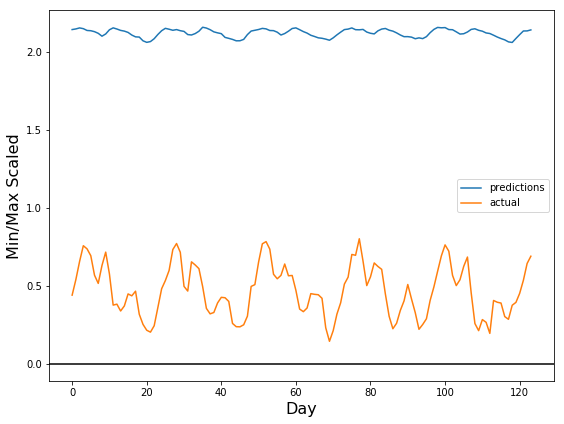

In [80]:
predictions_test = predictions
actuals_test = actuals

lower_lim = 0
upper_lim = 124
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_facecolor('white')
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Min/Max Scaled',fontsize=16)
plt.tight_layout()
plt.plot(predictions[lower_lim:upper_lim]);
plt.plot(actuals[lower_lim:upper_lim]);
# plt.plot(actuals)
plt.axhline(y=0, color='black');
plt.legend(['predictions','actual'])
plt.show()